In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from google.colab import files

print(" Libraries loaded successfully")


 Libraries loaded successfully


In [5]:

df_raw = pd.read_csv('/content/Watches Bags Accessories.csv')

df_raw.head()


,Title,Rating in Stars,Rating Count,Sold Count,Voucher,Delivery,Currency,Current Price,Original Price,Link,Category
0,Yfashion Cartoon Electronic Watch Life Water...,4.6/5,707,6K Sold,0,Free Delivery,Rs.,287,Rs. 520,//www.daraz.pk/products/y-led-3-i258744118-s14...,Kids Watches
1,"100% Imported LED watch for men , boys and Kid...",4.3/5,293,1K Sold,0,0,Rs.,270,Rs. 999,//www.daraz.pk/products/100-led-2023-i40167553...,Kids Watches
2,1 Cartoon Characters Analog Wrist Watch For Ki...,4.5/5,57,452 Sold,0,Free Delivery,Rs.,225,Rs. 750,//www.daraz.pk/products/1-i423737473-s20070599...,Kids Watches
3,M3 Touch LED Bracelet Digital Watch Band Good ...,4.6/5,51,332 Sold,0,Free Delivery,Rs.,160,Rs. 299,//www.daraz.pk/products/m3-led-led-i432456407-...,Kids Watches
4,led Watches For Boys and Girls and kids,4.4/5,54,476 Sold,0,Free Delivery,Rs.,198,Rs. 300,//www.daraz.pk/products/led-i398157365-s192654...,Kids Watches


In [6]:
df = df_raw.copy()
df.columns = [c.strip() for c in df.columns]

df = df.rename(columns={
    'Title':'title',
    'Rating in Stars':'rating_text',
    'Rating Count':'rating_count',
    'Sold Count':'sold_count',
    'Current Price':'current_price',
    'Original Price':'original_price',
    'Currency':'currency',
    'Voucher':'voucher',
    'Delivery':'delivery',
    'Link':'link',
    'Category':'category'
})

df.head()


,title,rating_text,rating_count,sold_count,voucher,delivery,currency,current_price,original_price,link,category
0,Yfashion Cartoon Electronic Watch Life Water...,4.6/5,707,6K Sold,0,Free Delivery,Rs.,287,Rs. 520,//www.daraz.pk/products/y-led-3-i258744118-s14...,Kids Watches
1,"100% Imported LED watch for men , boys and Kid...",4.3/5,293,1K Sold,0,0,Rs.,270,Rs. 999,//www.daraz.pk/products/100-led-2023-i40167553...,Kids Watches
2,1 Cartoon Characters Analog Wrist Watch For Ki...,4.5/5,57,452 Sold,0,Free Delivery,Rs.,225,Rs. 750,//www.daraz.pk/products/1-i423737473-s20070599...,Kids Watches
3,M3 Touch LED Bracelet Digital Watch Band Good ...,4.6/5,51,332 Sold,0,Free Delivery,Rs.,160,Rs. 299,//www.daraz.pk/products/m3-led-led-i432456407-...,Kids Watches
4,led Watches For Boys and Girls and kids,4.4/5,54,476 Sold,0,Free Delivery,Rs.,198,Rs. 300,//www.daraz.pk/products/led-i398157365-s192654...,Kids Watches


In [7]:
def parse_rating(x):
    if pd.isna(x):
        return np.nan
    match = re.search(r"(\d+(\.\d+)?)", str(x))
    return float(match.group(1)) if match else np.nan

df['rating'] = df['rating_text'].map(parse_rating)

df[['rating_text', 'rating']].head()

,rating_text,rating
0,4.6/5,4.6
1,4.3/5,4.3
2,4.5/5,4.5
3,4.6/5,4.6
4,4.4/5,4.4


In [8]:
# Rating Count & Sold Count

def parse_int(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace(",", "")
    match = re.search(r"(\d+)", s)
    return int(match.group(1)) if match else np.nan

df['rating_count_num'] = df['rating_count'].map(parse_int)

def parse_sold(x):
    if pd.isna(x):
        return 0
    s = str(x).lower().replace("sold", "").strip()

    if "k" in s:
        return int(float(s.replace("k", "")) * 1000)
    if "m" in s:
        return int(float(s.replace("m", "")) * 1_000_000)

    digits = re.sub(r"[^\d]", "", s)
    return int(digits) if digits else 0

df['sold'] = df['sold_count'].map(parse_sold)

df[['sold_count','sold']].head()


,sold_count,sold
0,6K Sold,6000
1,1K Sold,1000
2,452 Sold,452
3,332 Sold,332
4,476 Sold,476


In [9]:
# Price Cleaning & Discount Calculation

def parse_price(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace("Rs.", "").replace(",", "").strip()
    s = re.sub(r"[^\d\.]", "", s)
    return float(s) if s else np.nan

df['price'] = df['current_price'].map(parse_price)
df['original_price_num'] = df['original_price'].map(parse_price)

df['savings'] = df['original_price_num'] - df['price']
df['discount_pct'] = (df['savings'] / df['original_price_num'] * 100).round(2)
df['discount_pct'] = df['discount_pct'].fillna(0)

df[['price','original_price_num','discount_pct']].head()


,price,original_price_num,discount_pct
0,287.0,520.0,44.81
1,270.0,999.0,72.97
2,225.0,750.0,70.00
3,160.0,299.0,46.49
4,198.0,300.0,34.00


In [10]:
# Extract Brand (Heuristic)

def extract_brand(text):
    if pd.isna(text):
        return "Unknown"
    parts = str(text).split()
    # If uppercase token appears in first 3 words, likely the brand
    for p in parts[:3]:
        if p.isupper() and len(p) > 1:
            return p
    return parts[0]  # fallback

df['brand'] = df['title'].map(extract_brand)

df[['title','brand']].head()


,title,brand
0,Yfashion Cartoon Electronic Watch Life Water...,Yfashion
1,"100% Imported LED watch for men , boys and Kid...",LED
2,1 Cartoon Characters Analog Wrist Watch For Ki...,1
3,M3 Touch LED Bracelet Digital Watch Band Good ...,M3
4,led Watches For Boys and Girls and kids,led


In [11]:
# Final Clean Dataset

df_clean = df[[
    'title', 'brand', 'category', 'rating', 'rating_count_num', 'sold',
    'price', 'original_price_num', 'savings', 'discount_pct',
    'currency', 'delivery', 'link'
]].copy()

df_clean = df_clean[df_clean['price'].notna()].reset_index(drop=True)

df_clean.head()


,title,brand,category,rating,rating_count_num,sold,price,original_price_num,savings,discount_pct,currency,delivery,link
0,Yfashion Cartoon Electronic Watch Life Water...,Yfashion,Kids Watches,4.6,707,6000,287.0,520.0,233.0,44.81,Rs.,Free Delivery,//www.daraz.pk/products/y-led-3-i258744118-s14...
1,"100% Imported LED watch for men , boys and Kid...",LED,Kids Watches,4.3,293,1000,270.0,999.0,729.0,72.97,Rs.,0,//www.daraz.pk/products/100-led-2023-i40167553...
2,1 Cartoon Characters Analog Wrist Watch For Ki...,1,Kids Watches,4.5,57,452,225.0,750.0,525.0,70.00,Rs.,Free Delivery,//www.daraz.pk/products/1-i423737473-s20070599...
3,M3 Touch LED Bracelet Digital Watch Band Good ...,M3,Kids Watches,4.6,51,332,160.0,299.0,139.0,46.49,Rs.,Free Delivery,//www.daraz.pk/products/m3-led-led-i432456407-...
4,led Watches For Boys and Girls and kids,led,Kids Watches,4.4,54,476,198.0,300.0,102.0,34.00,Rs.,Free Delivery,//www.daraz.pk/products/led-i398157365-s192654...


In [12]:
df_clean.to_csv("cleaned_data.csv", index=False)

print("✓ cleaned_data.csv saved successfully")

files.download("cleaned_data.csv")


✓ cleaned_data.csv saved successfully


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

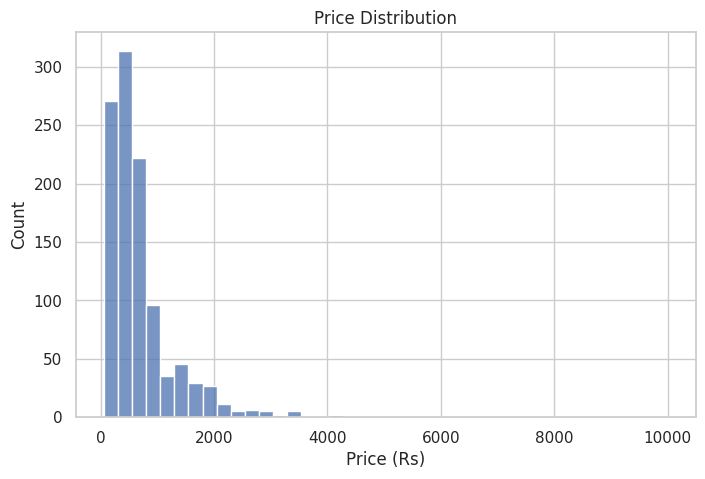

In [13]:
# Price Distribution

plt.figure(figsize=(8,5))
sns.histplot(df_clean['price'], bins=40)
plt.title("Price Distribution")
plt.xlabel("Price (Rs)")
plt.ylabel("Count")
plt.show()


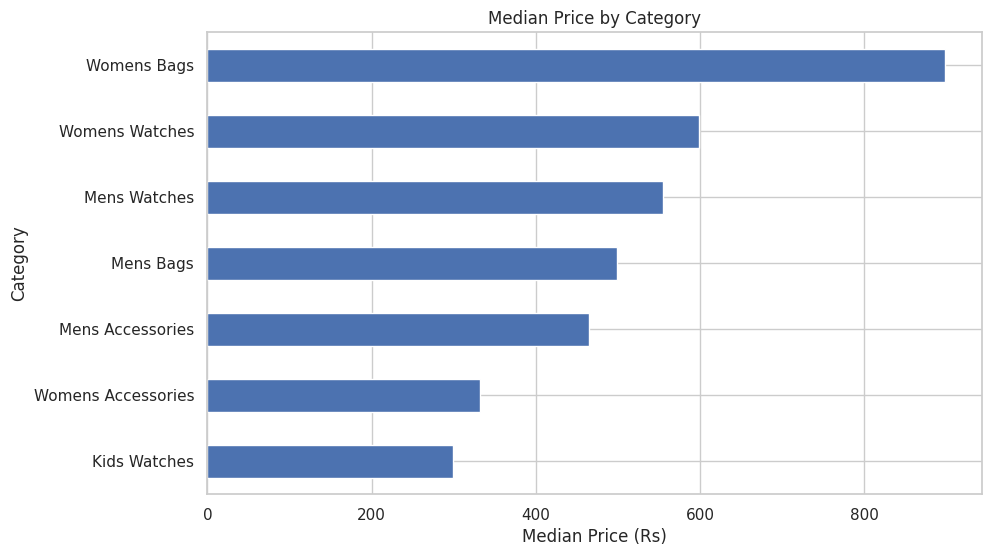

In [14]:
# Category Median Price

cat_median = df_clean.groupby("category")["price"].median().sort_values()

plt.figure(figsize=(10,6))
cat_median.plot(kind="barh")
plt.title("Median Price by Category")
plt.xlabel("Median Price (Rs)")
plt.ylabel("Category")
plt.show()


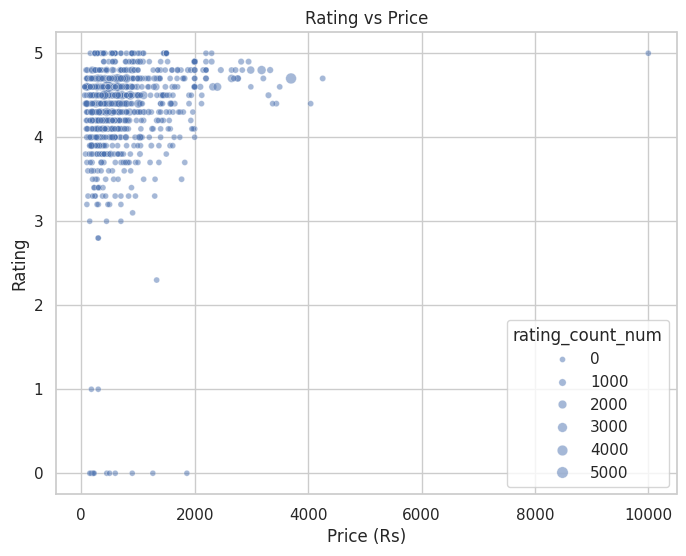

In [15]:
# Rating vs Price

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_clean.sample(min(2000, len(df_clean))),
    x="price",
    y="rating",
    size="rating_count_num",
    alpha=0.5
)
plt.title("Rating vs Price")
plt.xlabel("Price (Rs)")
plt.ylabel("Rating")
plt.show()


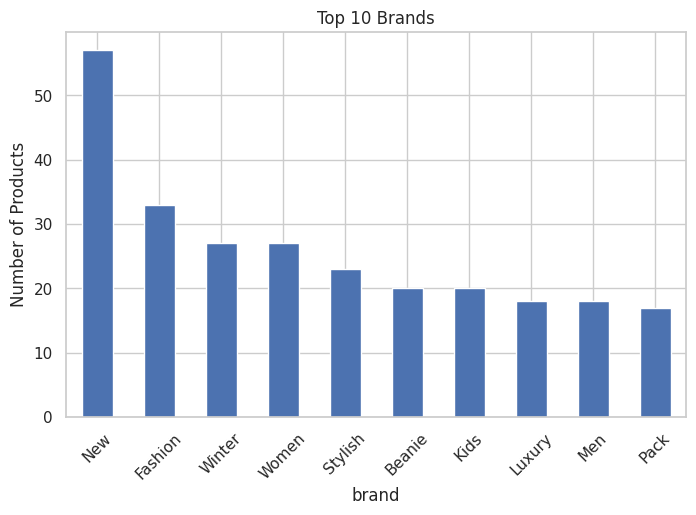

In [16]:
# Top Brands by Number of Listings

top_brands = df_clean['brand'].value_counts().head(10)

plt.figure(figsize=(8,5))
top_brands.plot(kind="bar")
plt.title("Top 10 Brands")
plt.ylabel("Number of Products")
plt.xticks(rotation=45)
plt.show()
